In [1]:
import os,sys,json
from collections import Counter
from datetime import datetime
from core.nsf_utils import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

In [2]:
years = range(1995, 2020)

In [3]:
colors = 5*["b", "orange", "g", "r", "olive", "teal", "c", "m"]
grant_types = ["Standard Grant", "Continuing grant"]
role_types = ["Principal Investigator", "Co-Principal Investigator",
              "Former Principal Investigator", "Former Co-Principal Investigator"]
def sct_plot(query, years):
    all_df, df = search_grant_data(query, years)
    cnt = Counter(all_df.id.values)
    print(df.loc[:, ["year", "id", "amount", "type", "role"]].to_string(index=False))
#     print([int(v) for v in df.id.values])
    plt.figure(figsize=(18,4))
    plt.title("{} {} {}-{} grants".format(query["firstname"], query["lastname"], years[0], years[-1]))
    plt.ylabel("Num PIs")
    plt.xlabel("Time")
#     plt.scatter(df.year, df.amount, alpha=0.5, color=[colors[grant_types.index(v)] for v in df.type])
#     print([cnt[i] for i in df.id])
    plt.scatter([datetime.strptime(t, "%m/%d/%Y") for t in df.start], [cnt[i] for i in df.id], alpha=0.5, 
                s=np.sqrt(df.amount),
                color=[colors[role_types.index(v)] for v in df.role])

In [4]:
query = {"firstname": "Antony", "lastname": "Hosking"}

 year       id  amount              type                           role
 1997  9711673  185000    Standard Grant         Principal Investigator
 1999  9988637  215000  Continuing grant         Principal Investigator
 2005   509377   30000    Standard Grant         Principal Investigator
 2005   540866  291999    Standard Grant         Principal Investigator
 2005   551658   99979    Standard Grant      Co-Principal Investigator
 2007   702240  275001  Continuing grant         Principal Investigator
 2007   720505   30000    Standard Grant         Principal Investigator
 2007   722210  484000    Standard Grant      Co-Principal Investigator
 2008   811691  422000    Standard Grant      Co-Principal Investigator
 2010  1042905   46800    Standard Grant      Co-Principal Investigator
 2013  1347630   12000    Standard Grant         Principal Investigator
 2014  1405939  286300    Standard Grant      Co-Principal Investigator
 2014  1408896  642319    Standard Grant         Principal Inves

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


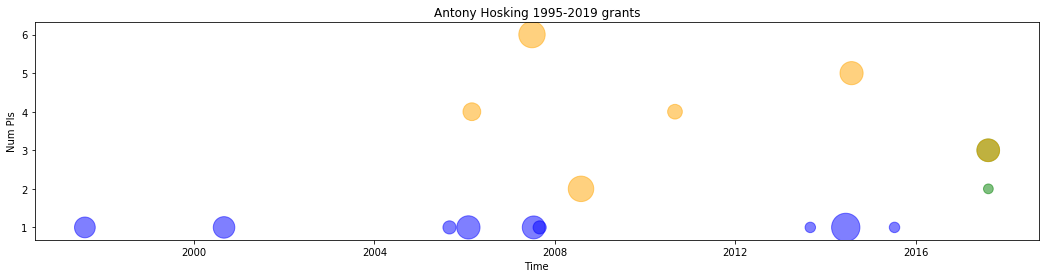

In [5]:
sct_plot(query, years)

In [6]:
def year_pub_plot(query, years):
    all_df, df = search_grant_data(query, years)
    cnt = Counter(all_df.id.values)
    x = []; y = []; s = []; c = []
    print(df.loc[:, ["id", "amount", "type", "role", "title"]].to_string(index=False))
#     print([int(v) for v in df.id.values])
    for gid, amount, gtype, role, title in df.loc[:, ["id", "amount", "type", "role", "title"]].values:
        res = grant_analysis(gid)
        if res == None:
            continue
        award_info, num_authors, num_citations = res
        x.append(datetime.strptime(award_info["startTime"], "%m/%d/%Y"))
        y.append(cnt[gid])
        s.append(award_info["numPublications"])
        c.append(colors[role_types.index(role)])
    
    plt.figure(figsize=(18,4))
    plt.title("{} {} {}-{} grants".format(query["firstname"], query["lastname"], years[0], years[-1]))
    plt.ylabel("Num PIs")
    plt.xlabel("Time")
    print("Num pubs", s)
#     plt.scatter(df.year, df.amount, alpha=0.5, color=[colors[grant_types.index(v)] for v in df.type])
#     print([cnt[i] for i in df.id])
    plt.scatter(x, y, alpha=0.5, s=[20*v for v in s], c=c, cmap=plt.get_cmap("viridis"))

      id  amount              type                           role                                              title
 9711673  185000    Standard Grant         Principal Investigator                         Compiling with Persistence
 9988637  215000  Continuing grant         Principal Investigator  Transactional Threads for Reliable Persistent ...
  509377   30000    Standard Grant         Principal Investigator  CSR---AES Collaborative: RuggedJ: Resilient Di...
  540866  291999    Standard Grant         Principal Investigator  ST-CRTS:    Collaborative:   Delivering on Ato...
  551658   99979    Standard Grant      Co-Principal Investigator  CRI: A Computational Infrastructure for Experi...
  702240  275001  Continuing grant         Principal Investigator  Scalable Concurrent Compacting Garbage Collect...
  720505   30000    Standard Grant         Principal Investigator  CSR-AES Collaborative: Encore/J: Transparently...
  722210  484000    Standard Grant      Co-Principal Investigato

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


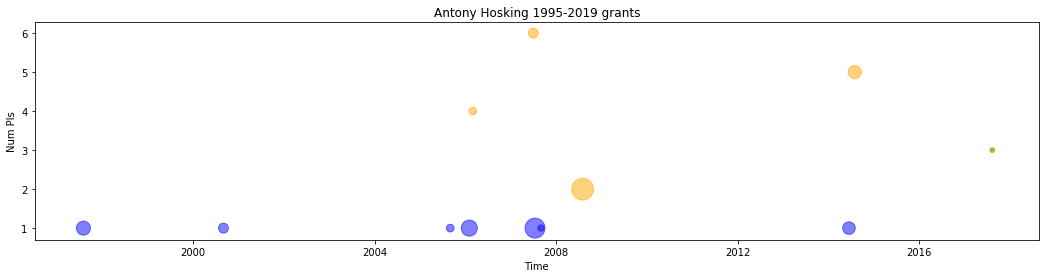

In [7]:
year_pub_plot(query, years)

In [8]:
def year_pub_networks(query, years):
    all_df, df = search_grant_data(query, years)
#     print(df.loc[:, ["id", "amount", "type", "role", "title"]].to_string(index=False))
#     print([int(v) for v in df.id.values])
    for gid, amount, gtype, role, title in df.loc[:, ["id", "amount", "type", "role", "title"]].values:
        G = get_author_G(gid)
        if len(G.nodes) == 0:
            continue
#         print(gid, G.nodes)
        fig = plt.figure(figsize=(15,8))

        pos = nx.spring_layout(G,k=0.20,iterations=20)
        e_colors = []
        n_colors = []
        weight = []
        for v,data in G.nodes.data():
            n_colors.append(cm.get_cmap("YlOrRd", 100)(100 if data["pi"] else 50)) 
        for u,v,d in G.edges.data():
            e_colors.append("black")
            weight.append(np.sqrt(len(G[u][v])))
        fig.suptitle("{} ------------------------------------------------------------------------------------------------------------------------".format(gid), ha="right")
        degree = [np.sqrt(v[1] * 100) for v in nx.degree(G)]
        nx.draw(G, pos, node_size=degree, node_color=n_colors)
        nx.draw_networkx_labels(G, pos)
    

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


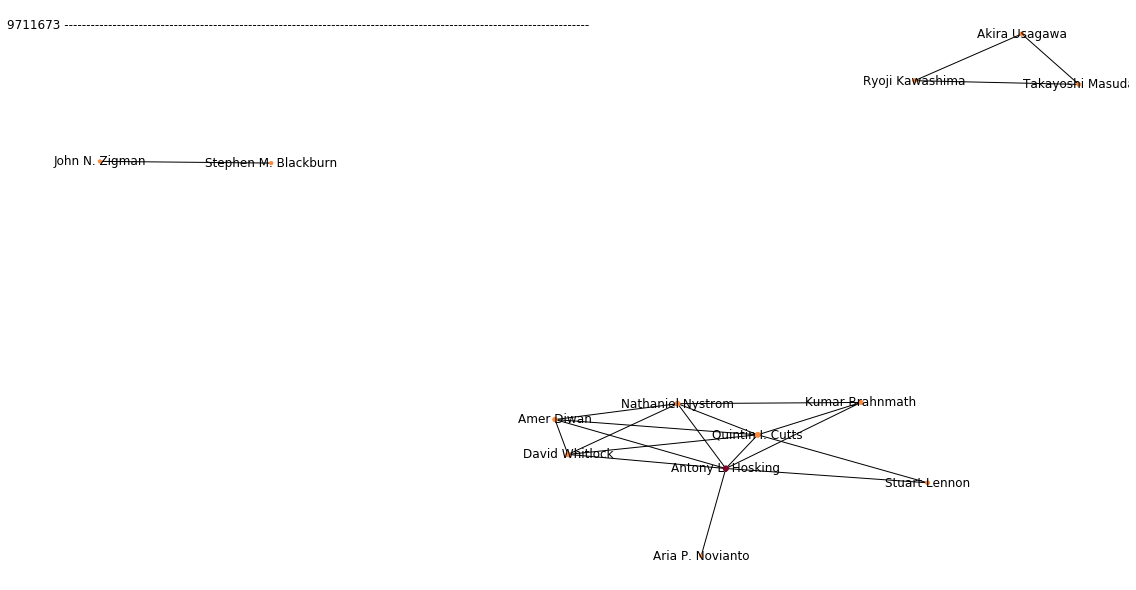

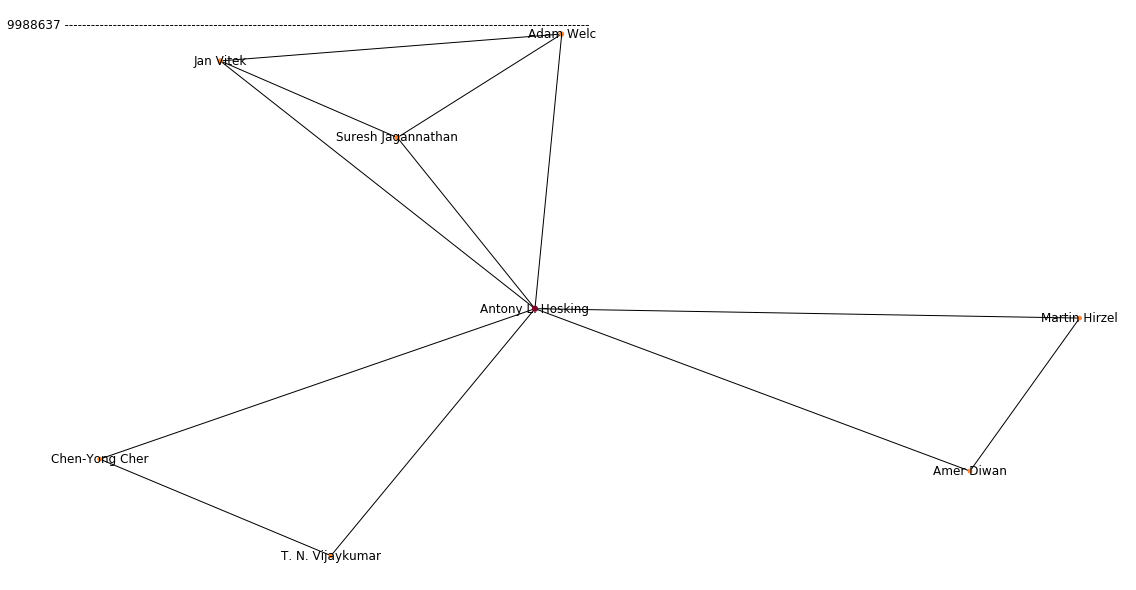

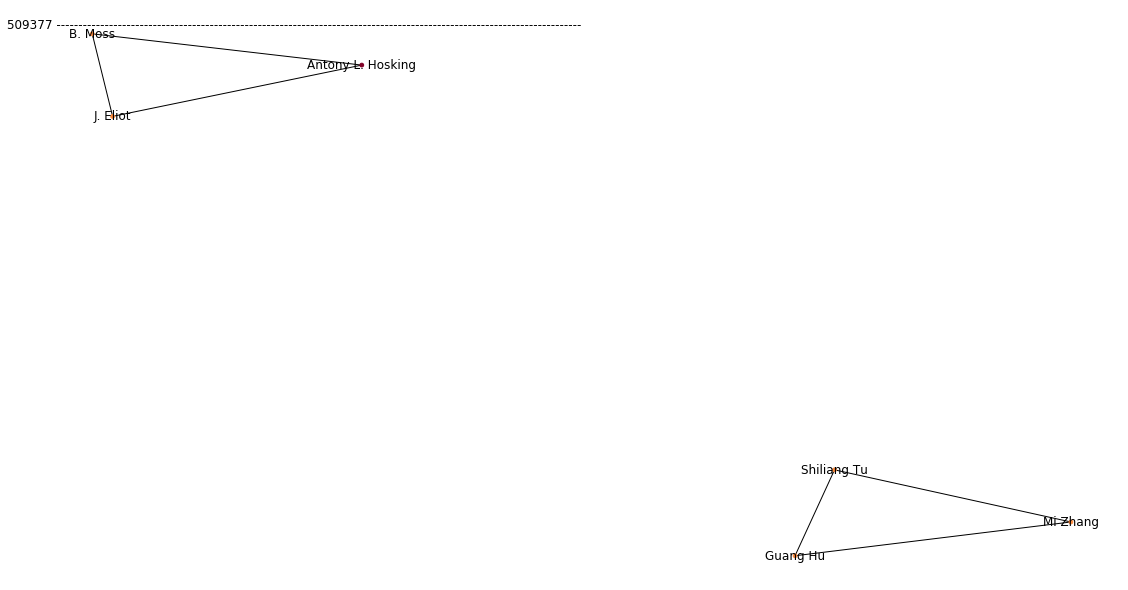

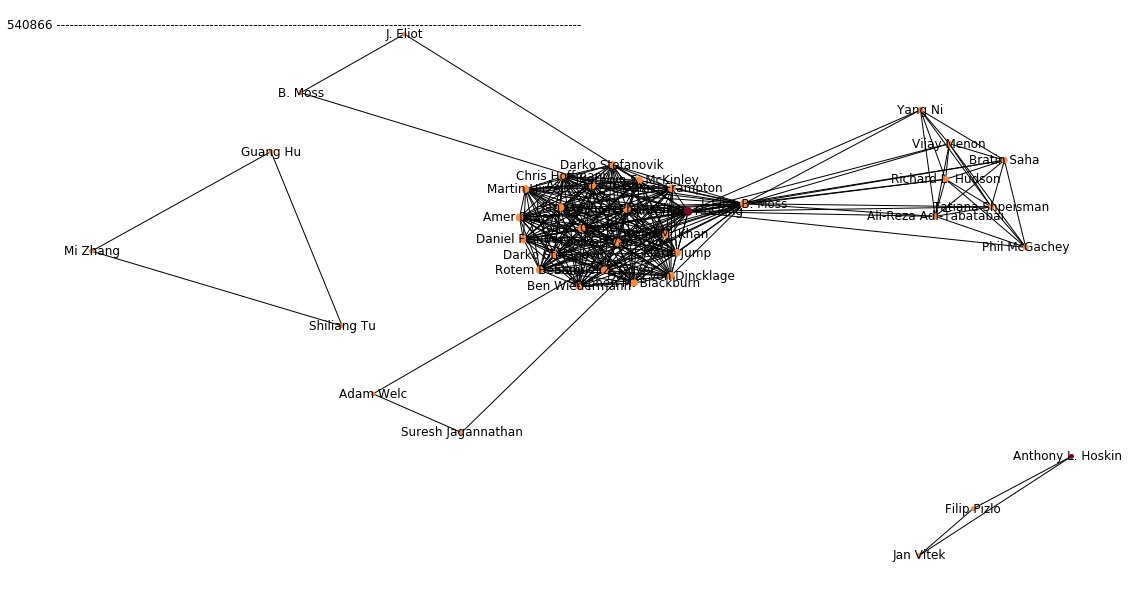

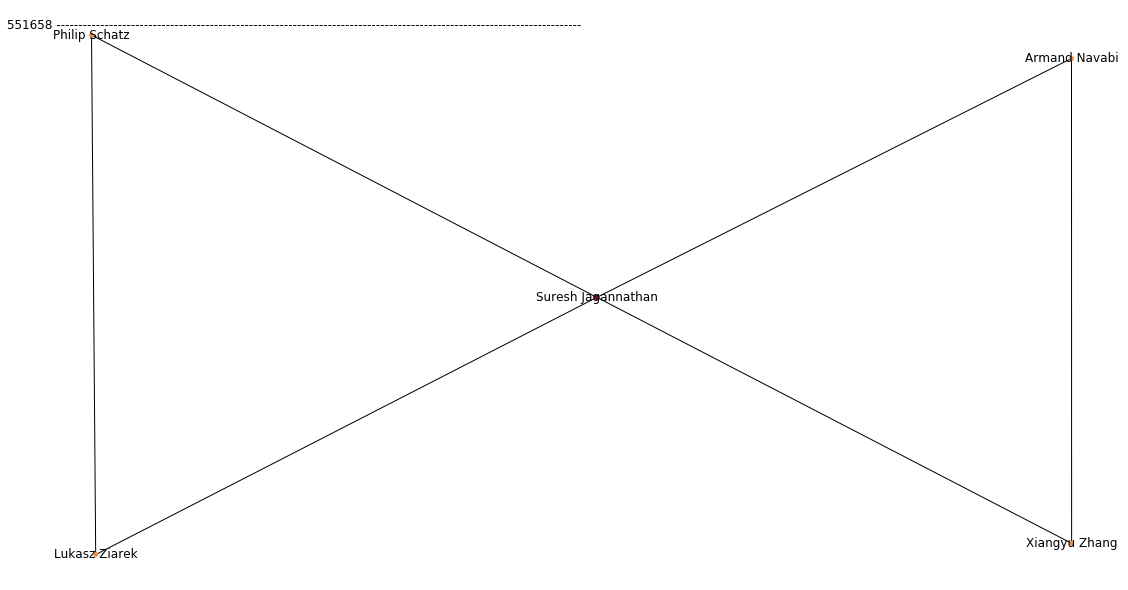

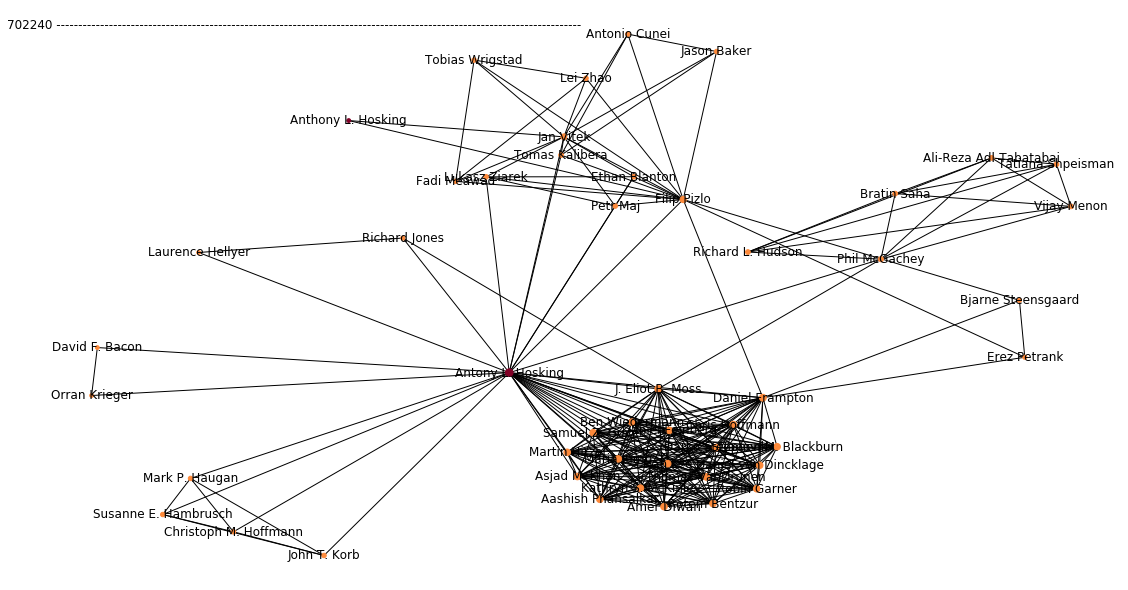

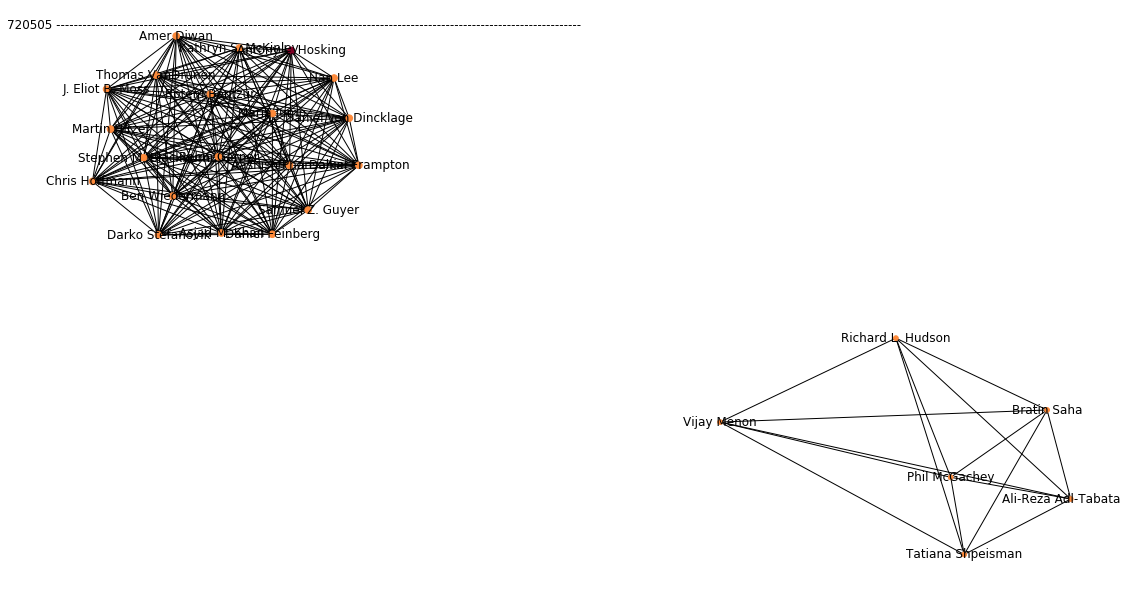

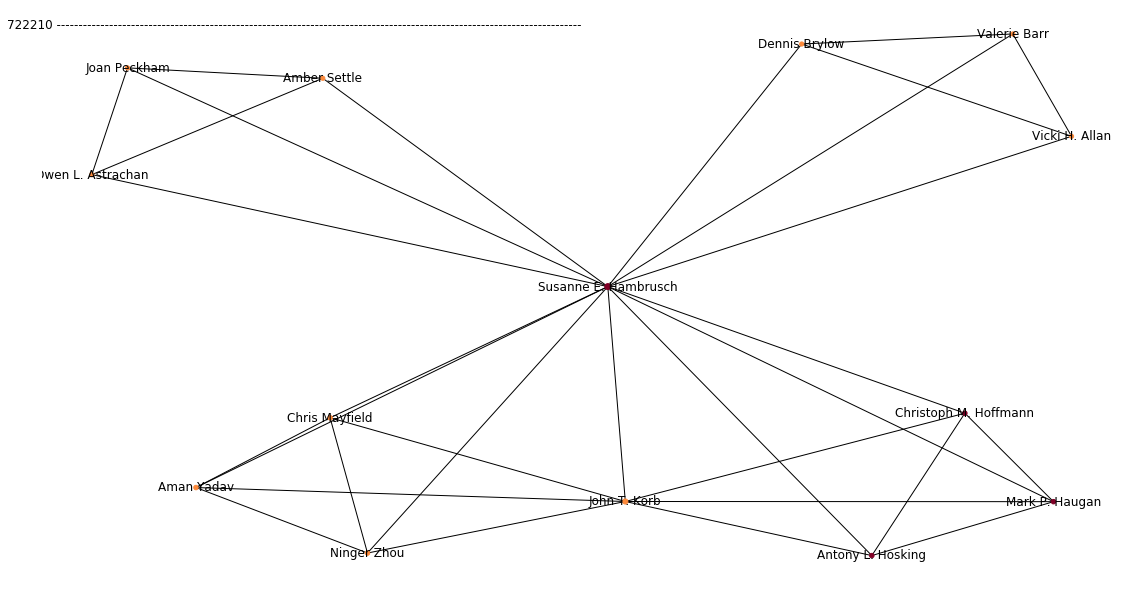

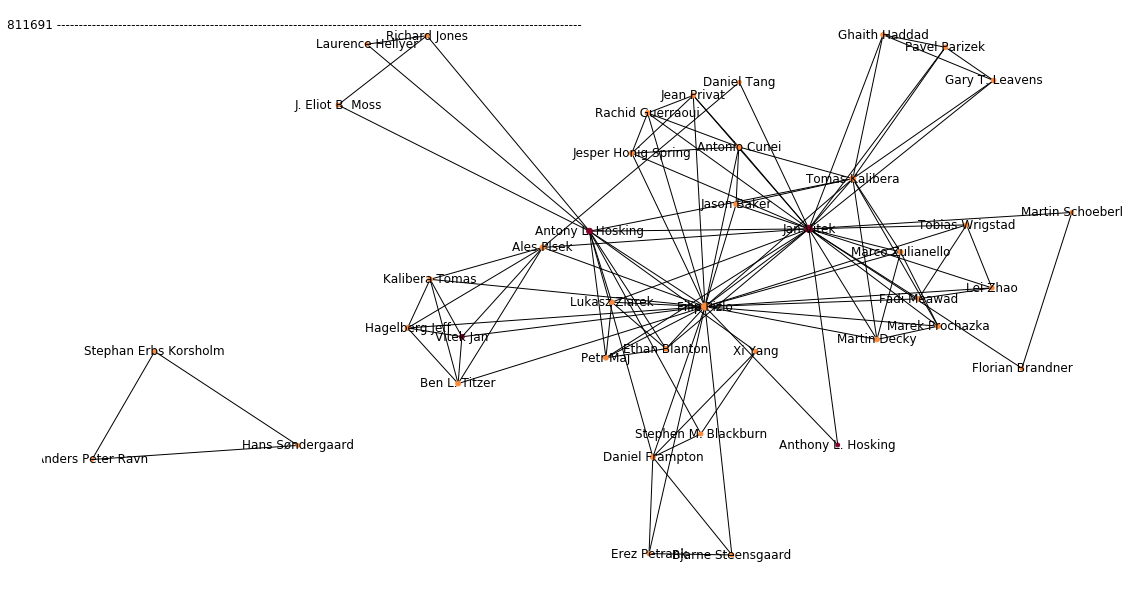

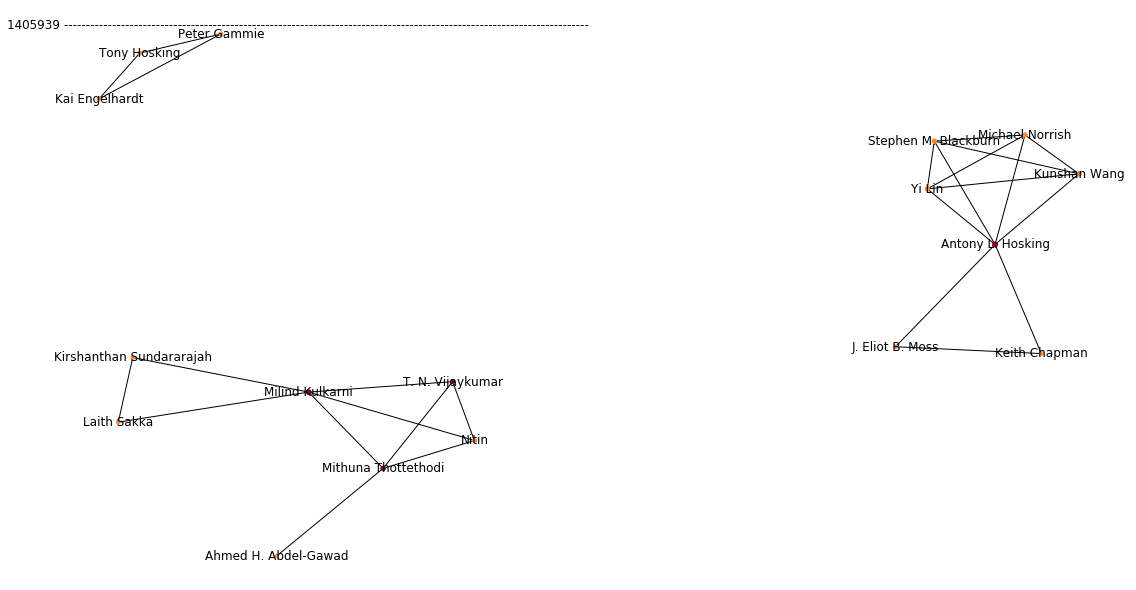

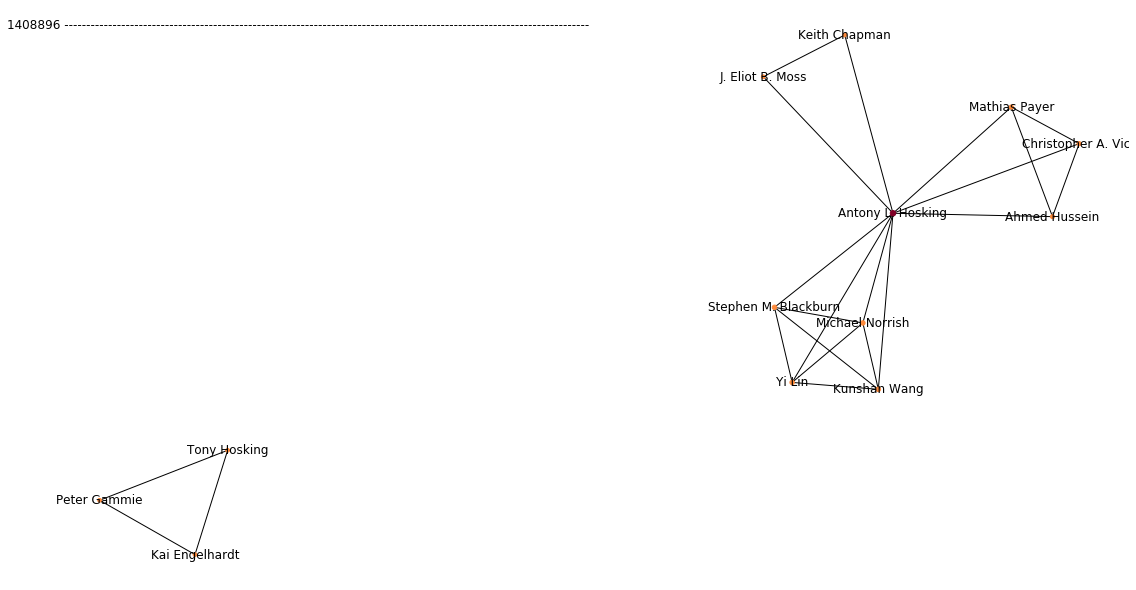

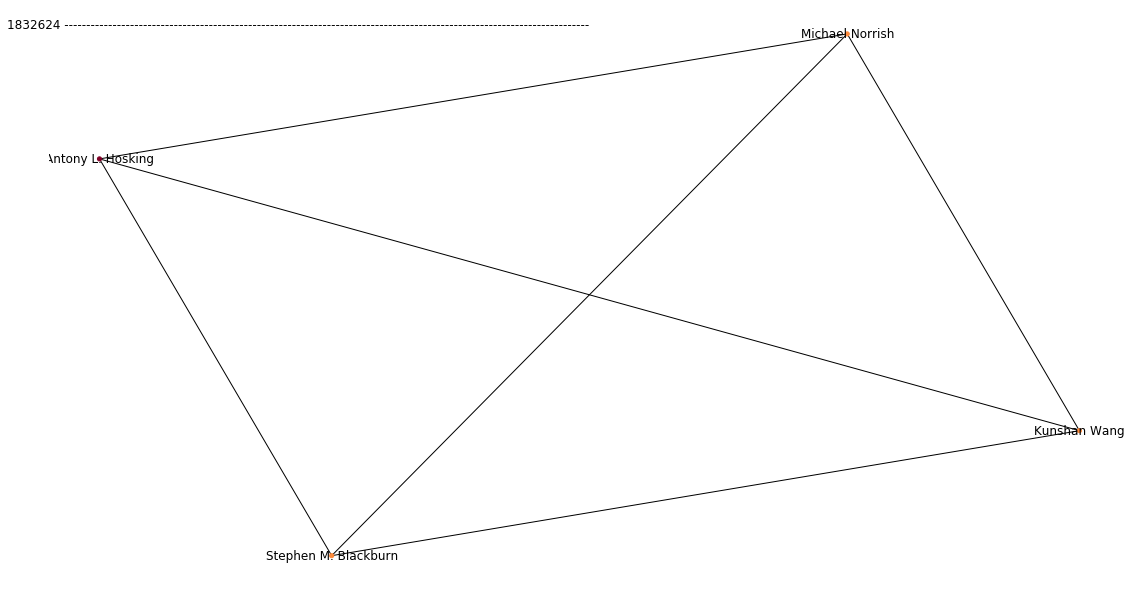

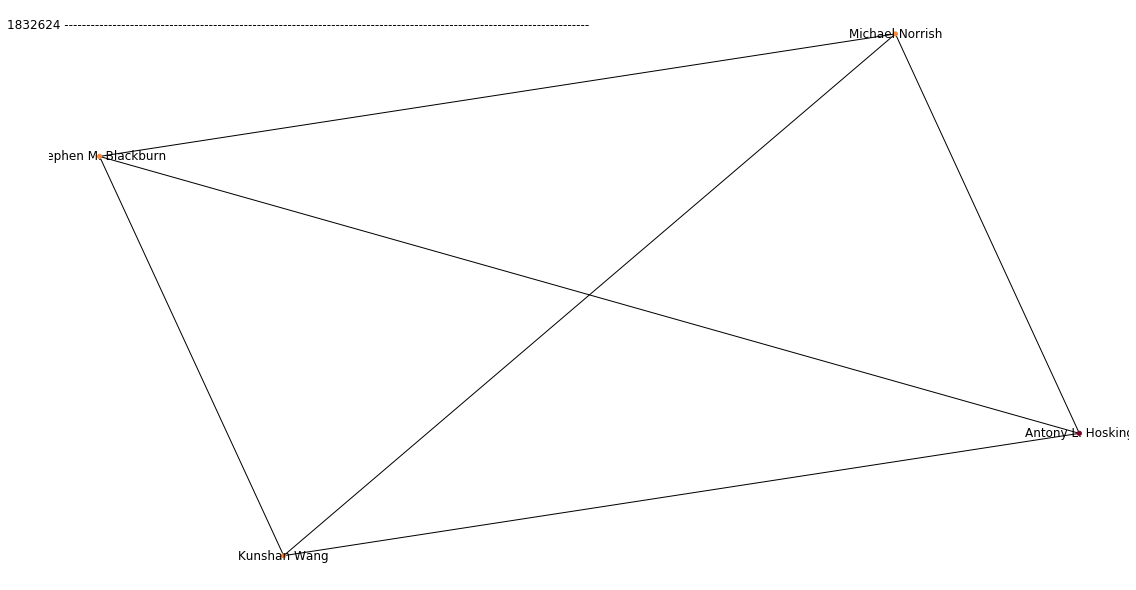

In [9]:
year_pub_networks(query, years)

In [10]:
def pub_cit_plot(query, years):
    _, df = search_grant_data(query, years)
    grant_ids = [int(v) for v in df.id.values]
    x = []; y = []; s = []; c = []
    for gid in grant_ids:
        res = grant_analysis(gid)
        if res == None:
            continue
        award_info, _, num_citations = res
        print(gid, num_citations)
        x.append(award_info["numPublications"])
        y.append(num_citations)
        s.append(award_info["awardAmount"])
        c.append(award_info["year"])
    plt.figure(figsize=(8,8))
    plt.title("{} {} {}-{} grants".format(query["firstname"], query["lastname"], years[0], years[-1]))
    plt.ylabel("Number of Citations per publication")
    plt.xlabel("Number of Publications")
    plt.scatter(x, y, alpha=0.5, 
                s=[np.sqrt(v) for v in s], c=c, cmap=plt.get_cmap("viridis"))
    plt.colorbar()

In [11]:
def amount_pub_plot(query, years):
    _, df = search_grant_data(query, years)
    grant_ids = [int(v) for v in df.id.values]
    x = []; y = []; s = []; c = []
    for gid in grant_ids:
        res = grant_analysis(gid)
        if res == None:
            continue
        award_info, _, num_citations = res
        print(gid, num_citations)
        x.append(award_info["awardAmount"])
        y.append(award_info["numPublications"])
        s.append(num_citations)
        c.append(award_info["year"])
    plt.figure(figsize=(8,8))
    plt.title("{} {} {}-{} grants".format(query["firstname"], query["lastname"], years[0], years[-1]))
    plt.ylabel("Number of Publications")
    plt.xlabel("Grant Amount")
    plt.scatter(x, y, alpha=0.5, 
                s=[100*np.sqrt(v) for v in s], c=c, cmap=plt.get_cmap("viridis"))
    plt.colorbar()

9711673 nan
9988637 nan
509377 nan
540866 142.9
551658 26.0
702240 29.125
720505 45.0
722210 16.0
811691 19.47826086956522
1042905 nan
1347630 nan
1405939 1.4444444444444444
1408896 2.125
1549774 nan
1832624 1.0
1832624 1.0
1833291 nan


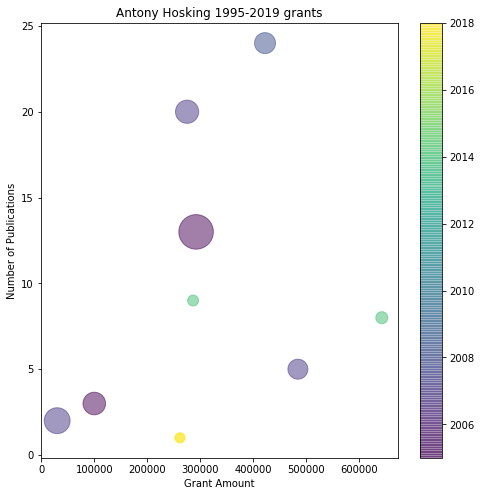

In [12]:
amount_pub_plot(query, years)

9711673 nan
9988637 nan
509377 nan
540866 142.9
551658 26.0
702240 29.125
720505 45.0
722210 16.0
811691 19.47826086956522
1042905 nan
1347630 nan
1405939 1.4444444444444444
1408896 2.125
1549774 nan
1832624 1.0
1832624 1.0
1833291 nan


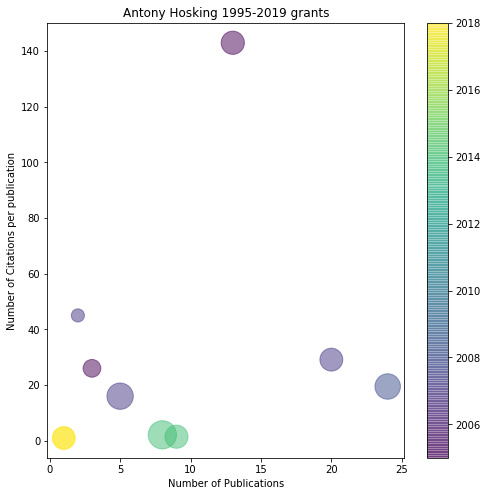

In [13]:
pub_cit_plot(query, years)

 year           id   amount              type                           role
 1999      9986030   100000    Standard Grant         Principal Investigator
 2000         2356   226419  Continuing grant         Principal Investigator
 2000        75447   197058    Standard Grant         Principal Investigator
 2000        85945  1784255  Continuing grant      Co-Principal Investigator
 2002      0208852   165000  Continuing grant         Principal Investigator
 2002      0219513   400000  Continuing grant         Principal Investigator
 2002      0239993    98340    Standard Grant         Principal Investigator
 2003       303587   550000  Continuing grant  Former Principal Investigator
 2004       438909   600000    Standard Grant         Principal Investigator
 2007       741620   149998    Standard Grant         Principal Investigator
 2008       808824   450000    Standard Grant         Principal Investigator
 2009       903629  2861583  Continuing grant      Co-Principal Investigator

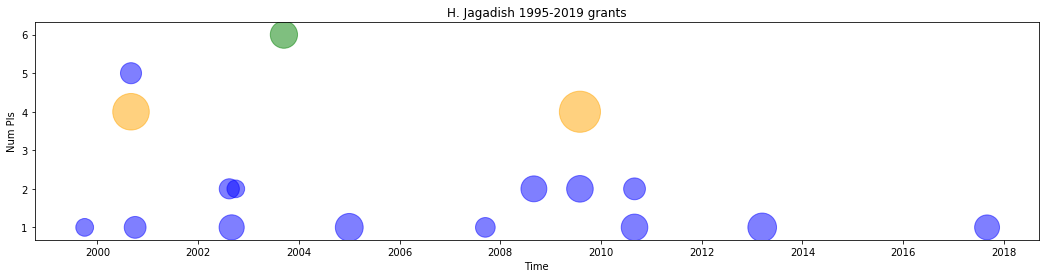

In [14]:
query = {"firstname": "H.", "lastname": "Jagadish"}
sct_plot(query, years)

          id   amount              type                           role                                              title
     9986030   100000    Standard Grant         Principal Investigator  SGER:  Managing Hierarchically Organized Data ...
        2356   226419  Continuing grant         Principal Investigator  Collaborative Research:  Data Mining:  Theory ...
       75447   197058    Standard Grant         Principal Investigator  Scalable Enterprise Systems: Coopetitive Desig...
       85945  1784255  Continuing grant      Co-Principal Investigator  ITR: Exploiting Style as Retrieval and Classif...
     0208852   165000  Continuing grant         Principal Investigator   Timber:  A Native XML Database Management System
     0219513   400000  Continuing grant         Principal Investigator  ITR/IIS: Querying Heterogeneous and Uncertain ...
     0239993    98340    Standard Grant         Principal Investigator  Workshop on Data Management Technology for Mol...
      303587   550000  C

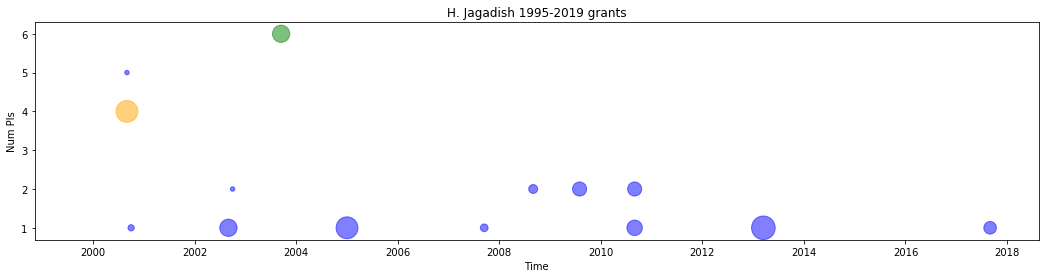

In [15]:
year_pub_plot(query, years)

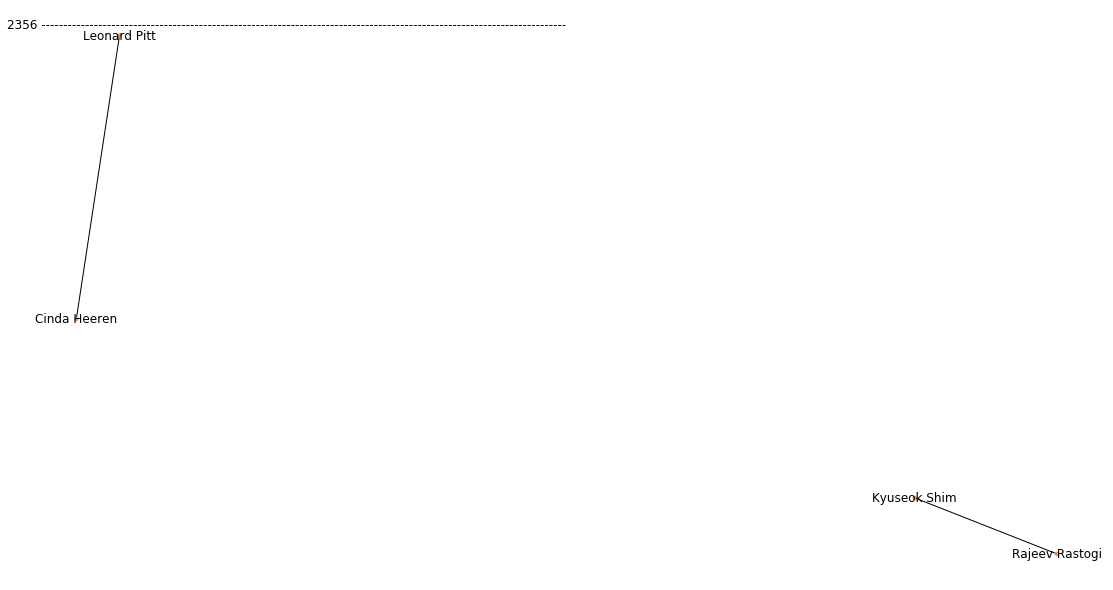

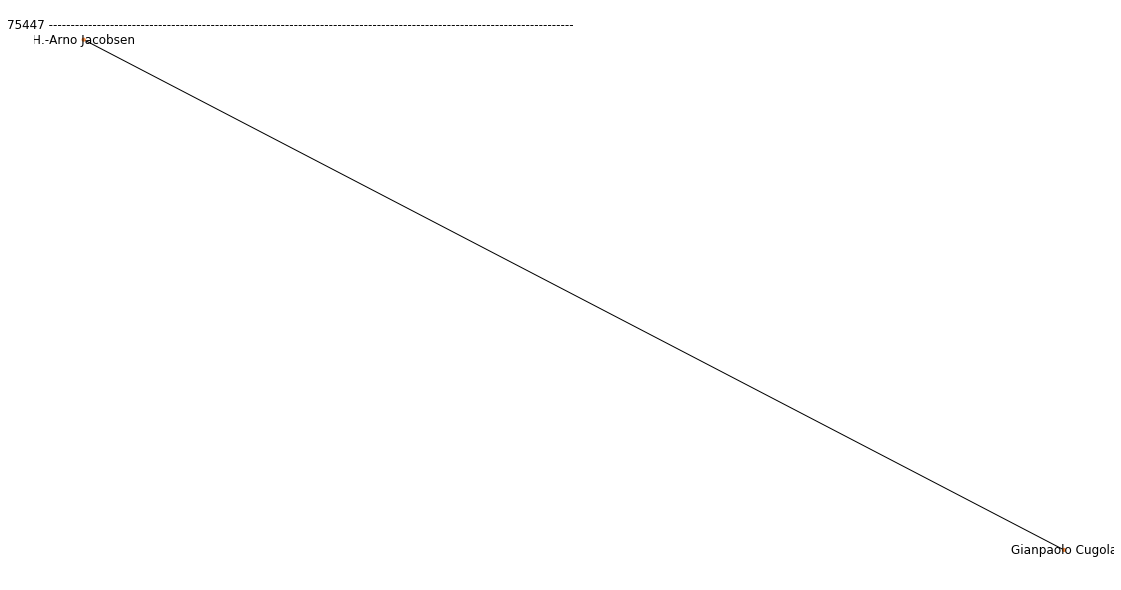

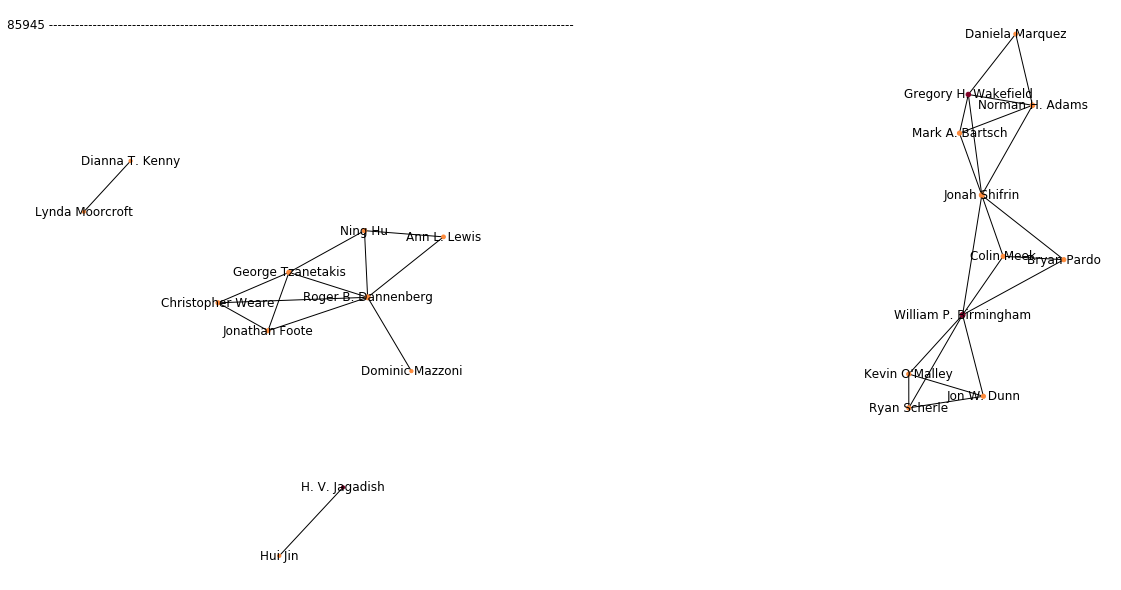

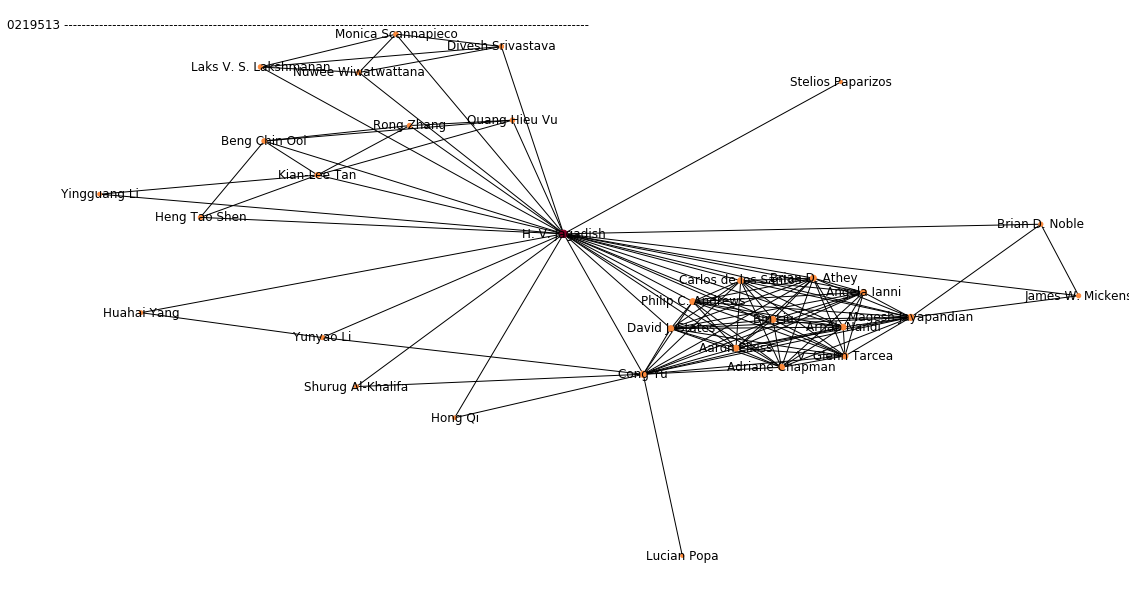

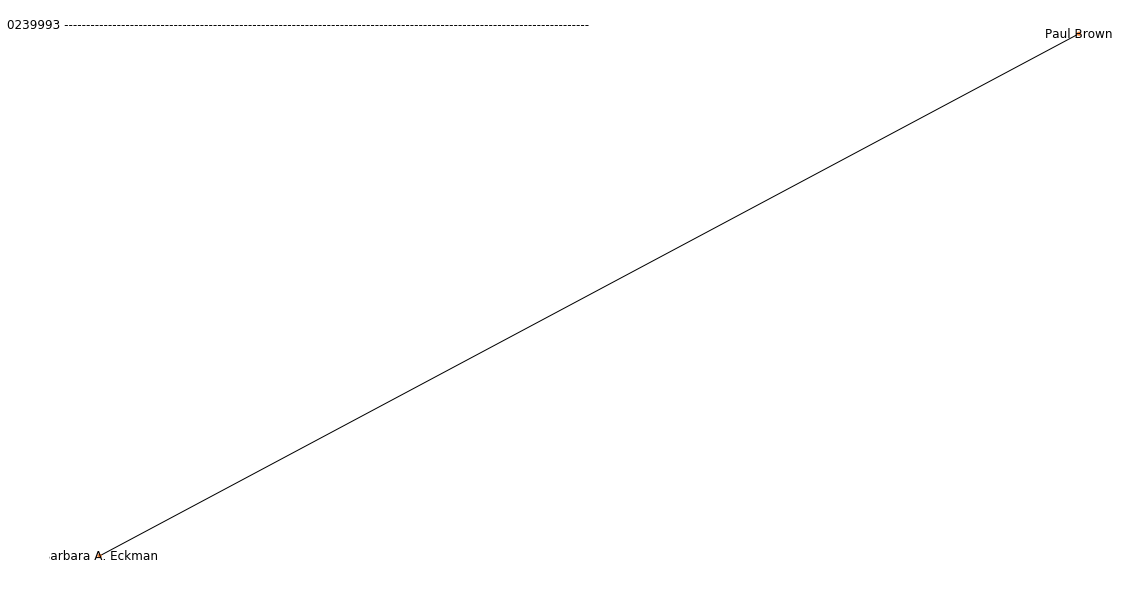

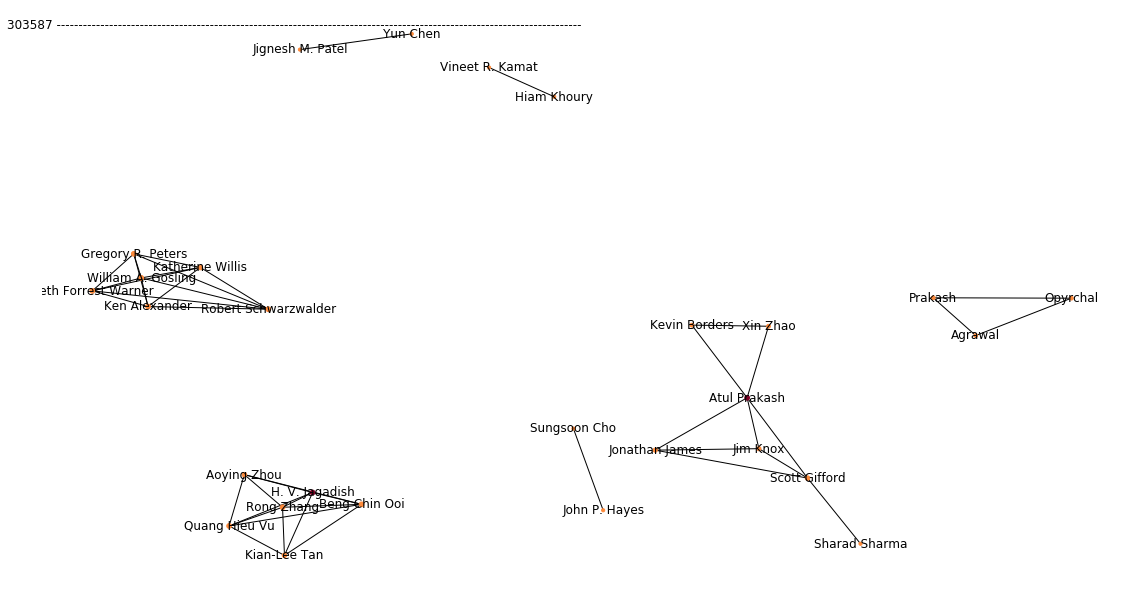

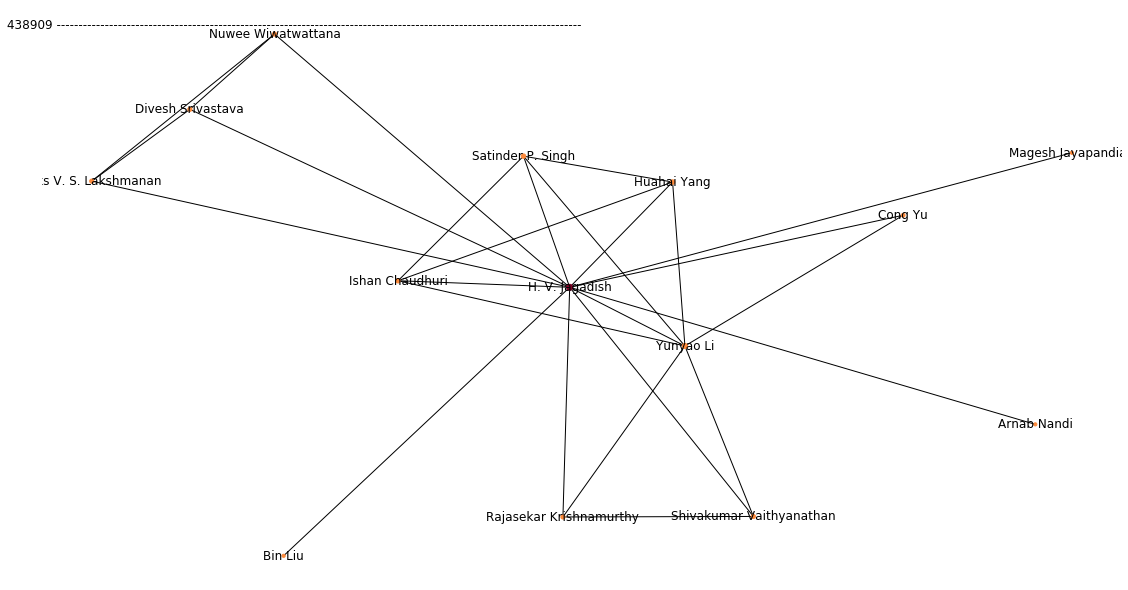

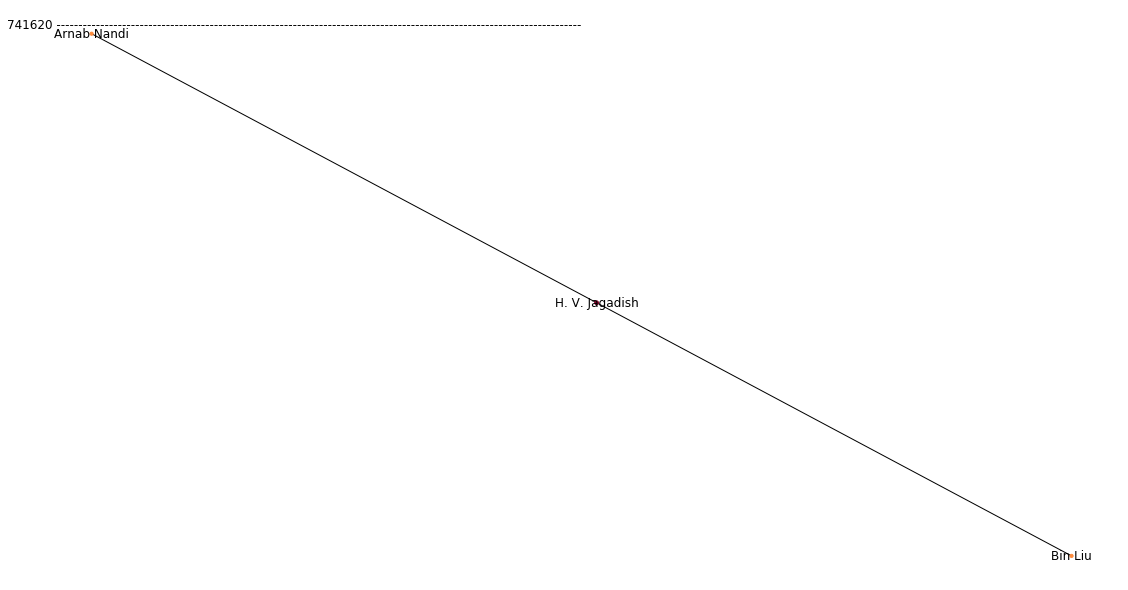

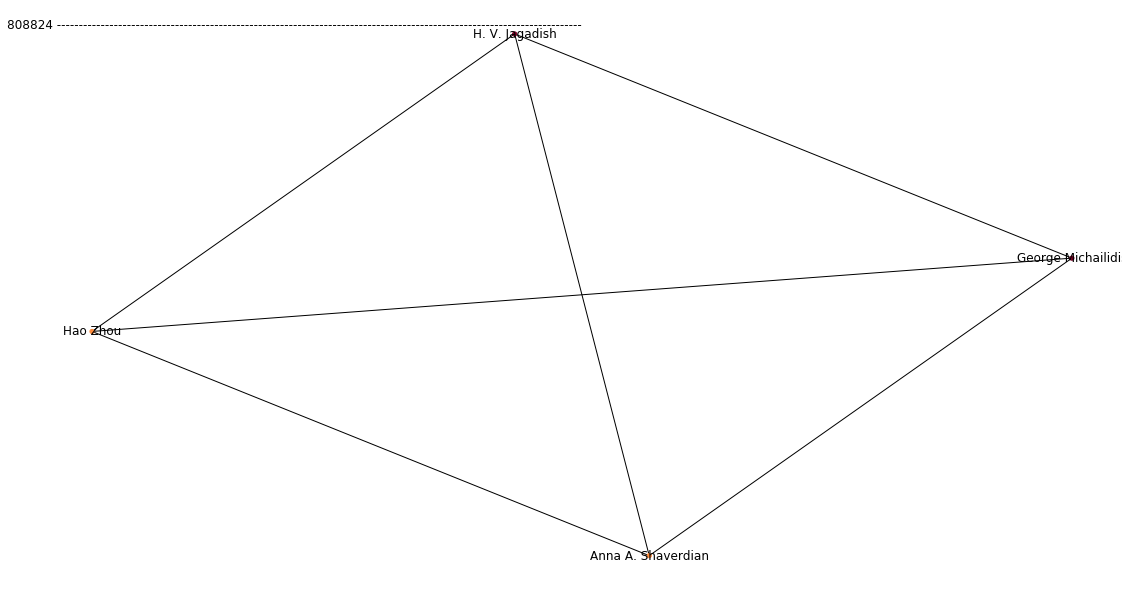

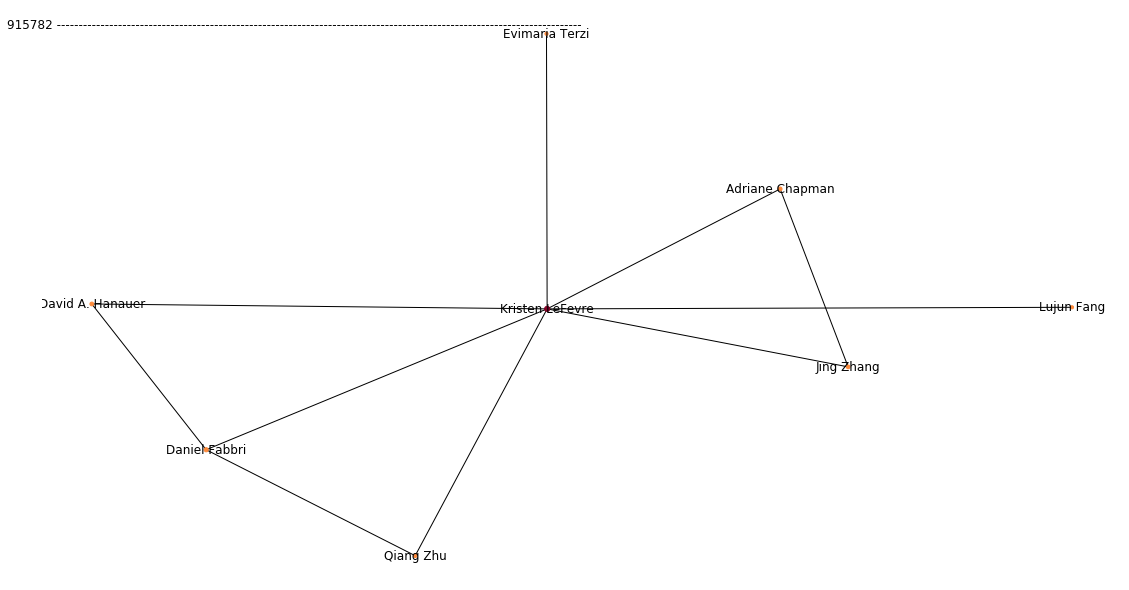

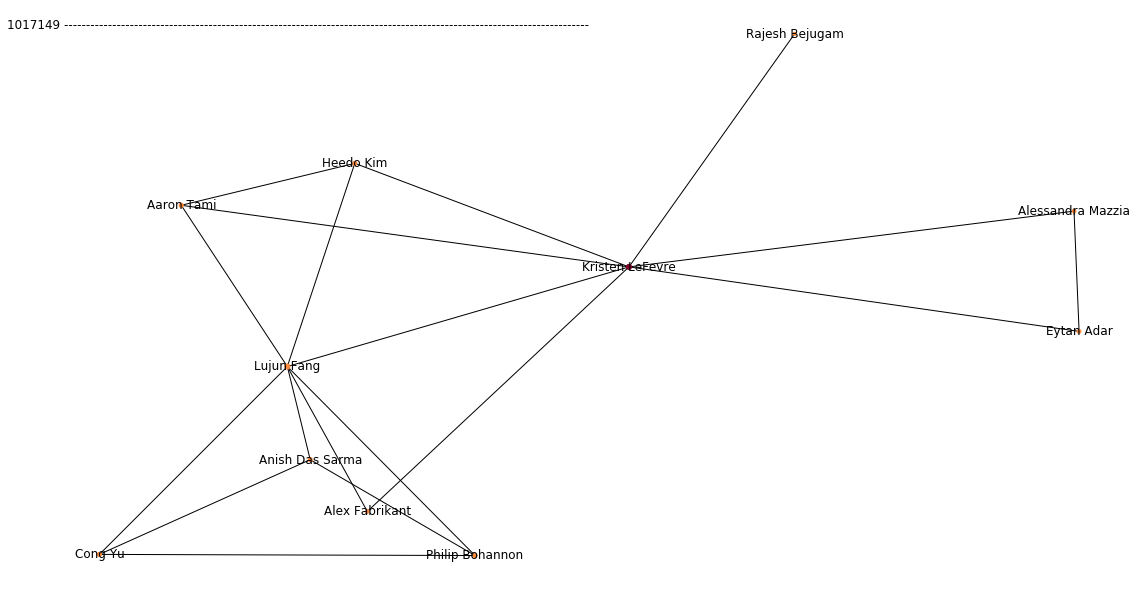

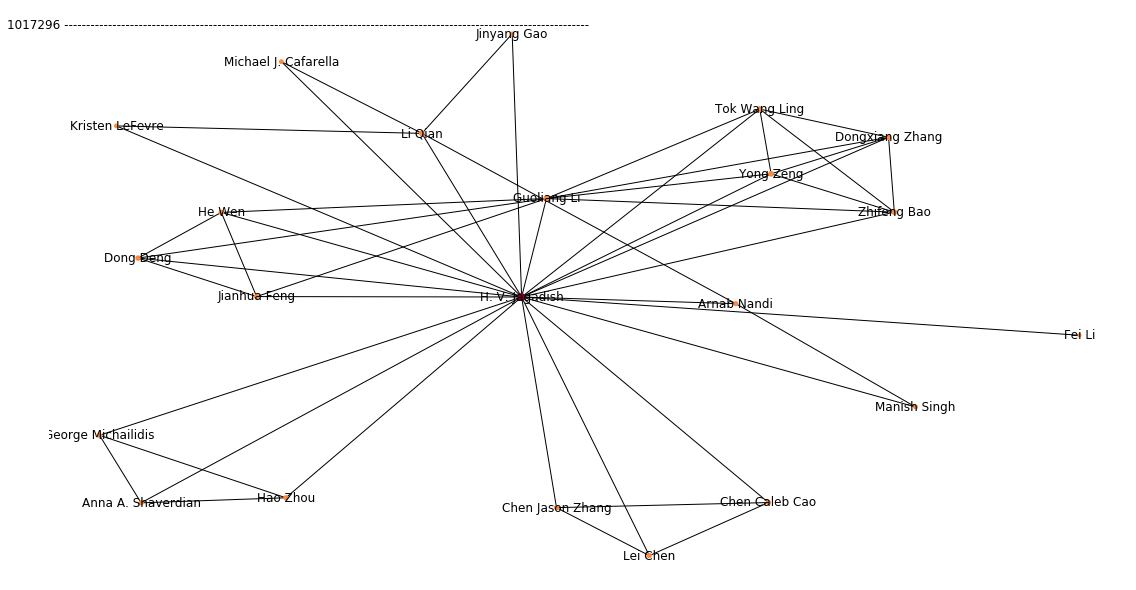

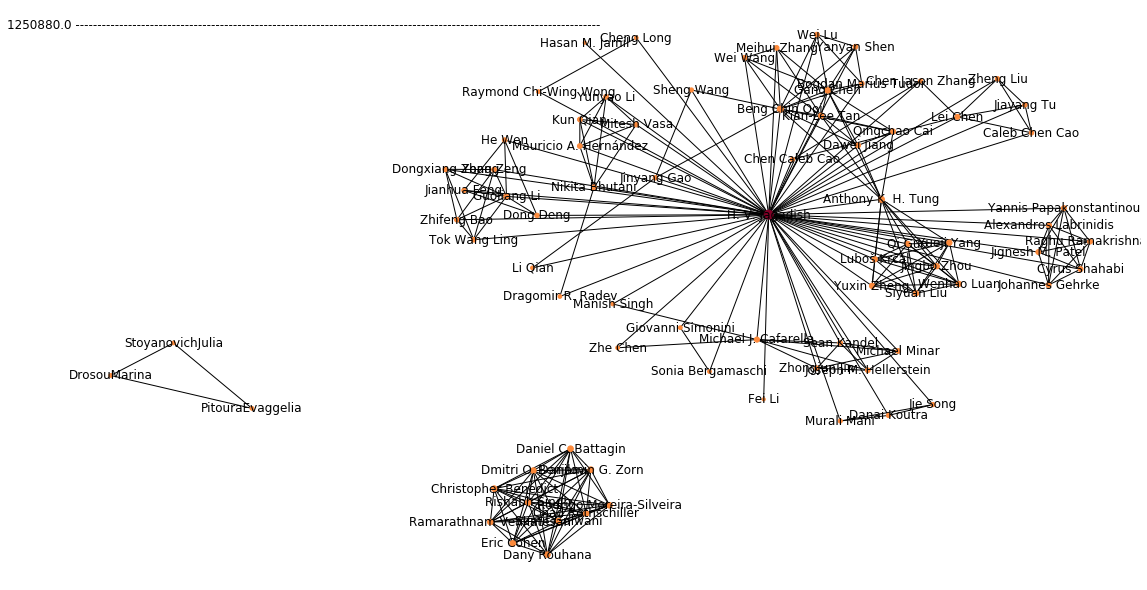

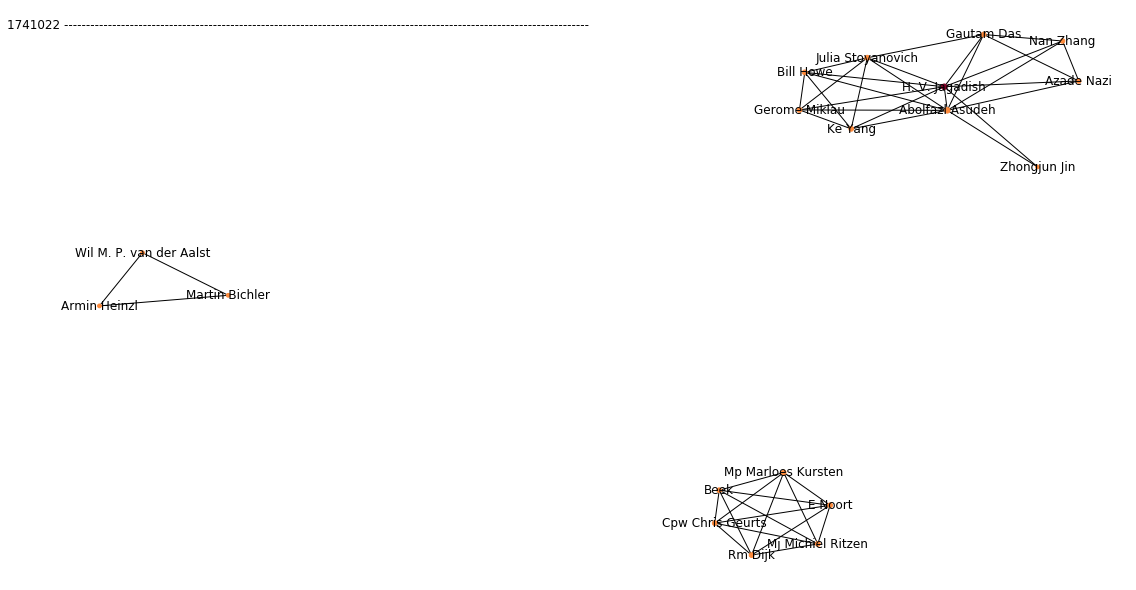

In [16]:
year_pub_networks(query, years)

9986030 nan
2356 nan
75447 nan
85945 nan
208852 nan
219513 97.93333333333334
239993 nan
303587 54.92857142857143
438909 39.583333333333336
741620 21.0
808824 4.0
903629 nan
915782 20.25
1017149 97.5
1017296 21.916666666666668
1250880 22.928571428571427
1741022 1.125


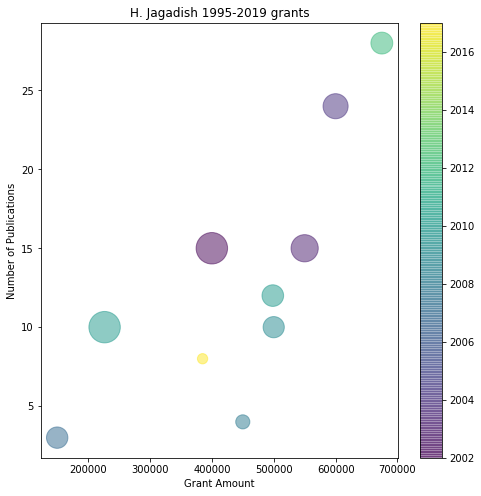

In [17]:
amount_pub_plot(query, years)

9986030 nan
2356 nan
75447 nan
85945 nan
208852 nan
219513 97.93333333333334
239993 nan
303587 54.92857142857143
438909 39.583333333333336
741620 21.0
808824 4.0
903629 nan
915782 20.25
1017149 97.5
1017296 21.916666666666668
1250880 22.928571428571427
1741022 1.125


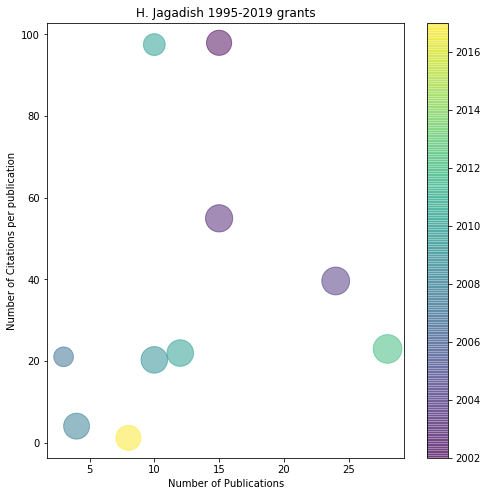

In [18]:
pub_cit_plot(query, years)

In [19]:
query = {"firstname": "H. Eugene", "lastname": "Stanley"}

 year           id    amount                   type                              role
 1995      9503008    397918       Continuing grant         Co-Principal Investigator
 1995      9521024     10000         Standard Grant            Principal Investigator
 1995      9553883   1200000       Continuing grant            Principal Investigator
 1995      9555194    450000         Standard Grant            Principal Investigator
 1996      9616565    858545         Standard Grant            Principal Investigator
 1997      9728854    285000       Continuing grant            Principal Investigator
 1998      9803732     15000         Standard Grant            Principal Investigator
 1998      9813599    529891       Continuing grant         Co-Principal Investigator
 2000         3685     12000         Standard Grant            Principal Investigator
 2000        96892    597800       Continuing grant            Principal Investigator
 2000        98771     99527         Standard Grant   

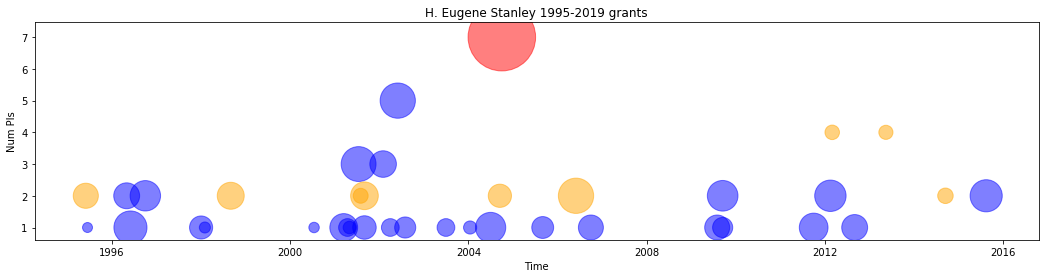

In [20]:
sct_plot(query, years)